# Is there a correlation between opioid deaths and demographics?

Part 1: Opioid-related deaths

In [35]:
# Dependencies and Setup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import requests
import time
from pathlib import Path
from scipy.stats import linregress

# File to Load
opioid_deaths = Path("opioid_death_counts.csv")

# Read Opioid-related Death Data File and store into Pandas DataFrames
opioid_deaths = pd.read_csv(opioid_deaths)

# Preview the Data
opioid_deaths

,Year,State,Total Opioid Deaths
0,2017,Alabama,0.000000
1,2017,Alaska,92.500000
2,2017,Arizona,886.857143
3,2017,Arkansas,0.000000
4,2017,California,0.000000
...,...,...,...
235,2022,Virginia,2126.750000
236,2022,Washington,1819.833333
237,2022,West Virginia,1154.833333
238,2022,Wisconsin,1469.833333


In [36]:
# Ensure that 'Year' and 'Total_Opioid_Deaths' are numeric
opioid_deaths['Year'] = pd.to_numeric(opioid_deaths['Year'], errors='coerce')
opioid_deaths['Total Opioid Deaths'] = pd.to_numeric(opioid_deaths['Total Opioid Deaths'], errors='coerce')

# Sort the data by State and Year
opioid_deaths = opioid_deaths.sort_values(['State', 'Year'])

# Display the new DataFrame
opioid_deaths

,Year,State,Total Opioid Deaths
0,2017,Alabama,0.000000
48,2018,Alabama,0.000000
96,2019,Alabama,0.000000
144,2021,Alabama,0.000000
192,2022,Alabama,1015.777778
...,...,...,...
47,2017,Wyoming,44.888889
95,2018,Wyoming,41.416667
143,2019,Wyoming,42.333333
191,2021,Wyoming,60.750000


In [37]:
# Calculate the national average for each year
national_avg = opioid_deaths.groupby('Year')['Total Opioid Deaths'].mean().reset_index()
national_avg['State'] = 'National Average'
national_avg = national_avg.rename(columns={'Total Opioid Deaths': 'Total Opioid Deaths'})

# Append the national average data to the original DataFrame
opioid_deaths_with_avg = pd.concat([opioid_deaths, national_avg], ignore_index=True)

# Display the updated DataFrame
opioid_deaths_with_avg

,Year,State,Total Opioid Deaths
0,2017,Alabama,0.000000
1,2018,Alabama,0.000000
2,2019,Alabama,0.000000
3,2021,Alabama,0.000000
4,2022,Alabama,1015.777778
...,...,...,...
240,2017,National Average,559.282035
241,2018,National Average,714.867436
242,2019,National Average,883.542048
243,2021,National Average,1410.772743


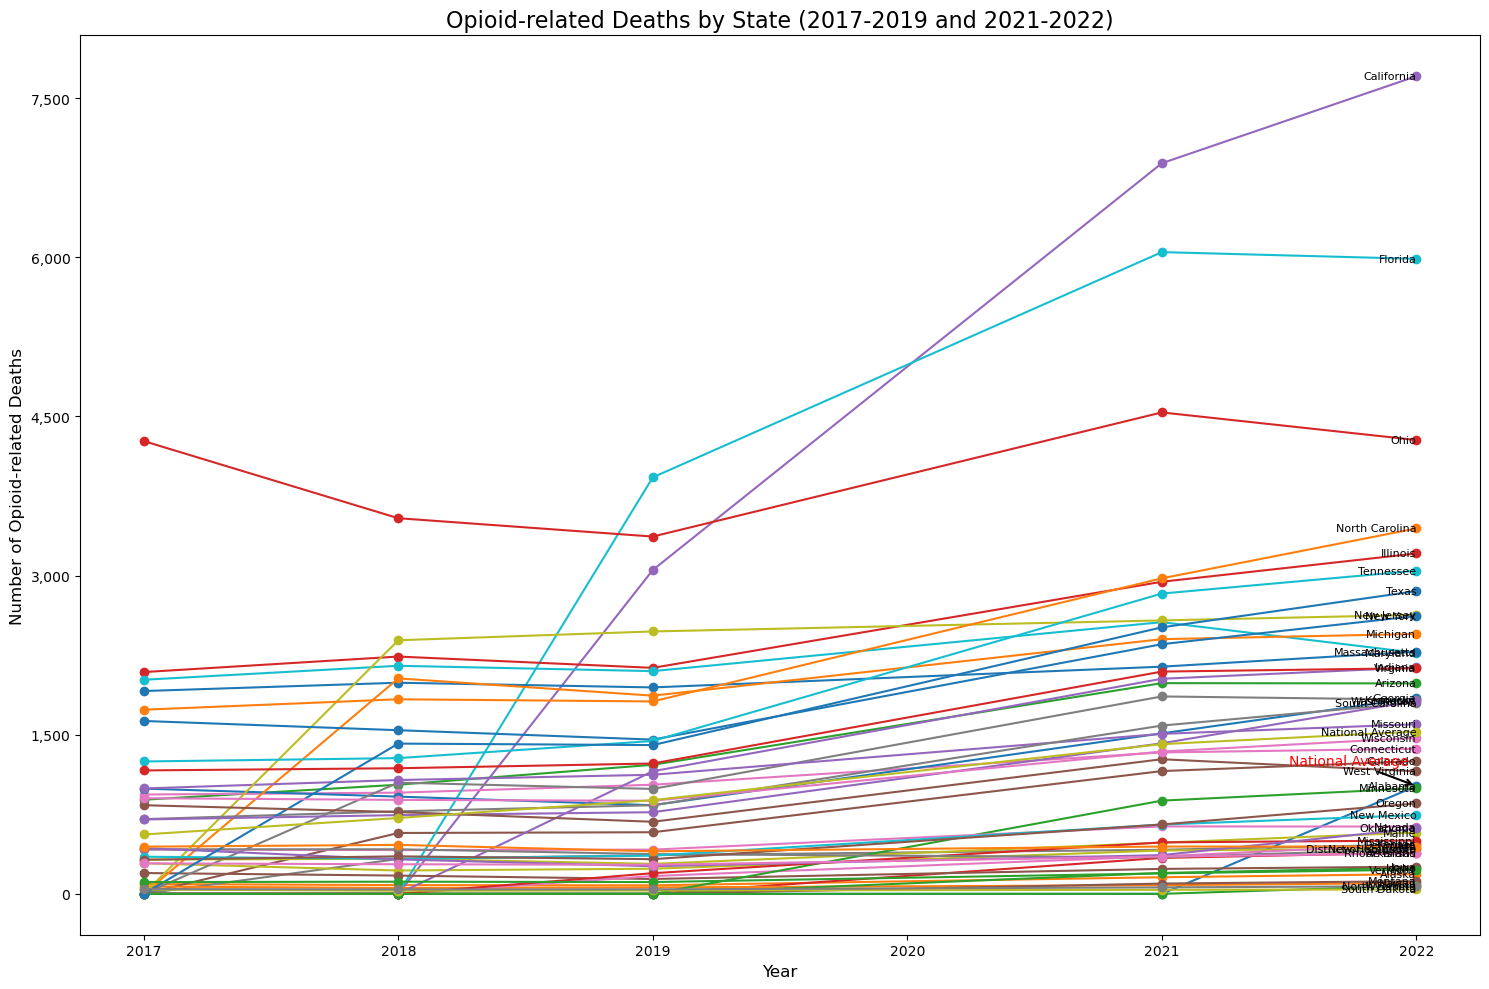

In [38]:
# Create a figure
plt.figure(figsize=(15, 10))

# Plot each state separately and add labels
for state in opioid_deaths_with_avg['State'].unique():
    state_data = opioid_deaths_with_avg[opioid_deaths_with_avg['State'] == state]
    plt.plot(state_data['Year'], state_data['Total Opioid Deaths'], marker='o', label=state)
    
# Add state label at the end of each line
    last_year = state_data['Year'].iloc[-1]
    last_value = state_data['Total Opioid Deaths'].iloc[-1]
    plt.text(last_year, last_value, state, fontsize=8, ha='right', va='center')

# Add an arrow annotating the national average line
# Example: Annotate the latest year (2022) data point of the national average line
latest_data_point = opioid_deaths_with_avg[opioid_deaths_with_avg['Year'] == 2022].iloc[0]
plt.annotate(
    'National Average',  # Annotation text
    xy=(latest_data_point['Year'], latest_data_point['Total Opioid Deaths']),
    xytext=(latest_data_point['Year'] - 0.5, latest_data_point['Total Opioid Deaths'] + 200),  # Adjust text position
    arrowprops=dict(facecolor='red', arrowstyle='->', lw=1.5),
    fontsize=10,
    color='red'
)

# Add title and labels
plt.title('Opioid-related Deaths by State (2017-2019 and 2021-2022)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Opioid-related Deaths', fontsize=12)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

In [39]:
# Create a dataframe showing opioid-related deaths occurred in all states in 2022
opioid_deaths_2022 = opioid_deaths[(opioid_deaths['Year'] == 2022)]

# Create a new DataFrame from the grouped data
opioid_deaths_2022 = pd.DataFrame(opioid_deaths_2022)

# Display the shape of the filtered DataFrame
opioid_deaths_2022

,Year,State,Total Opioid Deaths
192,2022,Alabama,1015.777778
193,2022,Alaska,185.583333
194,2022,Arizona,1983.250000
195,2022,Arkansas,387.833333
196,2022,California,7705.583333
197,2022,Colorado,1250.083333
198,2022,Connecticut,1367.250000
199,2022,Delaware,464.500000
200,2022,District of Columbia,425.583333
201,2022,Florida,5984.500000


C:\Users\PuiKi.Chan\AppData\Local\Temp\ipykernel_14068\3420890830.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


ValueError: aspect must be finite and positive 

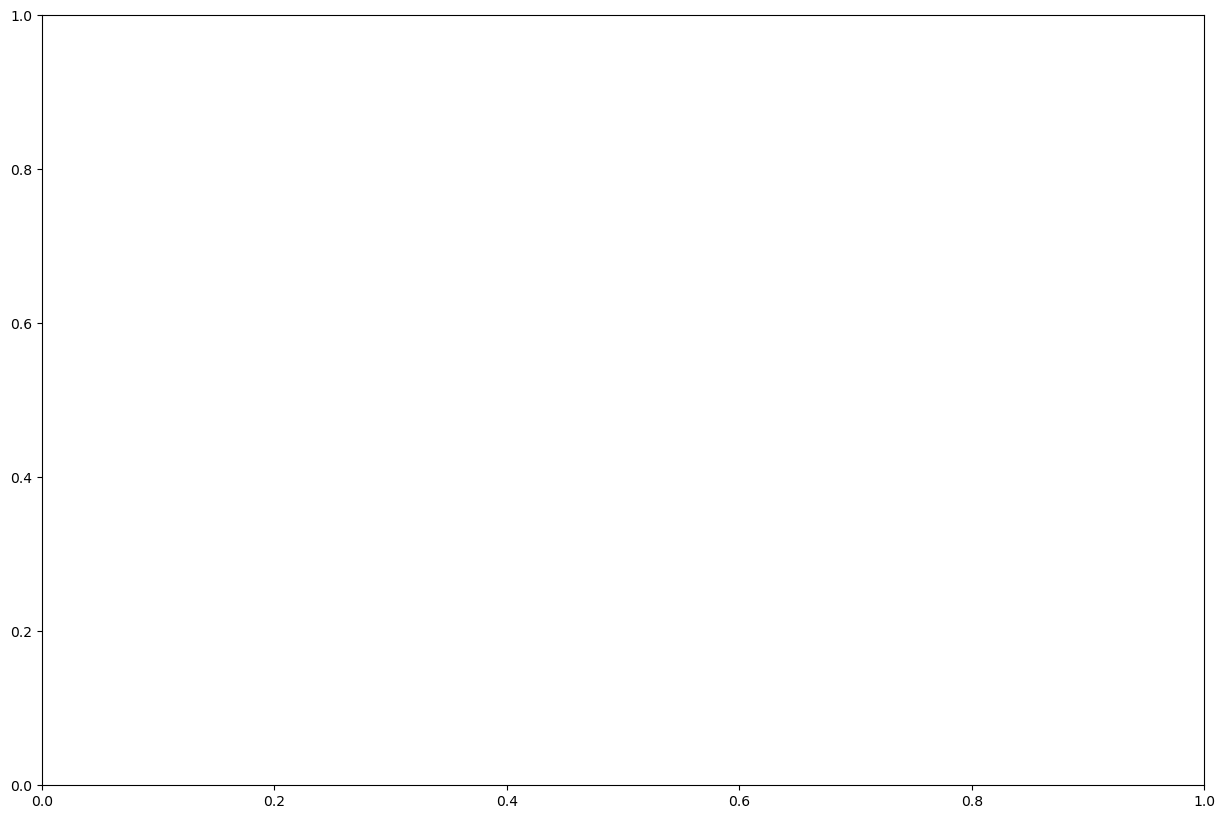

In [50]:
us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us_states = us_states[(us_states['continent'] == 'North America') & (us_states['name'].isin([
        'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
        'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Maryland',
        'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nevada', 'New Hampshire', 'New Jersey',
        'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Rhode Island', 'South Carolina',
        'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]))]

opioid_deaths_2022 = pd.DataFrame({
    'State': [
        'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
        'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Maryland',
        'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nevada', 'New Hampshire', 'New Jersey',
        'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Rhode Island', 'South Carolina',
        'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
    ],
    'Total Opioid Deaths': [
        1015.777778, 185.583333, 1983.250000, 387.833333, 7705.583333, 1250.083333, 1367.250000, 464.500000, 425.583333,
        5984.500000, 1846.750000, 101.500000, 246.916667, 3207.916667, 2133.666667, 256.250000, 466.166667, 1830.666667,
        577.666667, 2270.916667, 2281.750000, 2449.250000, 994.166667, 502.333333, 1598.500000, 119.416667, 634.000000,
        421.583333, 2628.916667, 741.916667, 2618.625000, 3443.666667, 76.000000, 4277.000000, 616.000000, 852.083333,
        380.500000, 1801.416667, 41.750000, 3045.333333, 2853.166667, 444.916667, 228.000000, 2126.750000, 1819.833333,
        1154.833333, 1469.833333, 72.250000
    ]
})

merged = us_states.merge(opioid_deaths_2022, how='left', left_on='name', right_on='State')

fig, ax = plt.subplots(1, figsize=(15, 10))

merged.plot(column='Total Opioid Deaths', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', ax=ax, legend=True, alpha=0.7)

ax.axis('off')

ax.set_aspect('equal')

ax.set_title('Opioid-Related Deaths per State in 2022', fontdict={'fontsize': '25', 'fontweight': '3'})

ax.annotate('Source: Centers for Disease Control and Prevention, 2022', xy=(0.1, .08), xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

plt.show()

C:\Users\PuiKi.Chan\AppData\Local\Temp\ipykernel_14068\1780665788.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


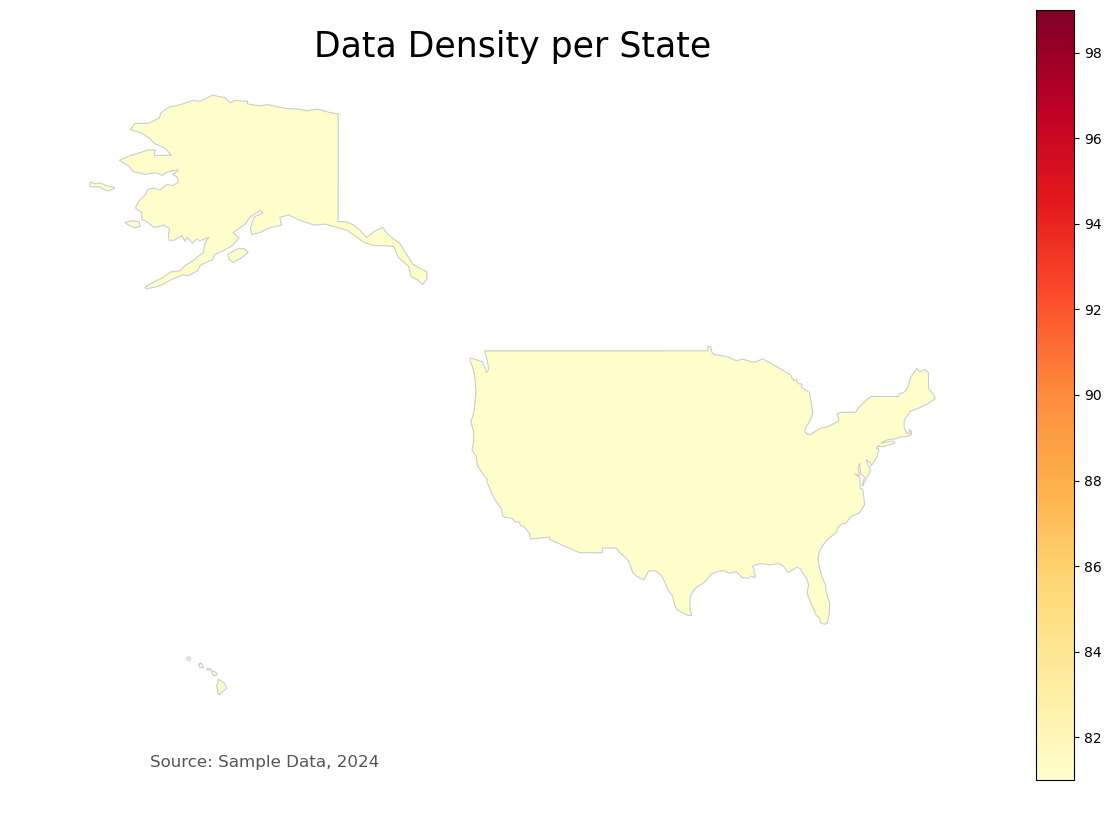

In [49]:
# Create a map of data density per state using cmap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load US states shapefile
us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us_states = us_states[us_states['continent'] == 'North America']
us_states = us_states[us_states['name'].isin(['United States of America'])]

# Create sample data for density per state
data = pd.DataFrame({
    'state': us_states.name,
    'density': np.random.randint(1, 100, len(us_states))
})

# Merge the data with the shapefile
merged = us_states.merge(data, how='left', left_on=['name'], right_on=['state'])

# Create the map
fig, ax = plt.subplots(1, figsize=(15, 10))

# Plot the data
merged.plot(column='density', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', ax=ax, legend=True)

# Remove axis
ax.axis('off')

# Add title
ax.set_title('Data Density per State', fontdict={'fontsize': '25', 'fontweight': '3'})

# Add source annotation
ax.annotate('Source: Sample Data, 2024', xy=(0.1, .08), xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Show the plot
plt.show()

In [ ]:
# Create a dataframe showing the five states with the highest rate of opioid-related death in the past ten years (2010-2020)
filtered_data = grouped_data_df[(grouped_data_df['Year'] >= 2010) & (grouped_data_df['Year'] <= 2020)]

# Create a new DataFrame from the grouped data
filtered_data_df = pd.DataFrame(filtered_data)
# Display the shape of the filtered DataFrame
filtered_data

State US needs to be removed for accurate top 5, or excluded


In [ ]:
# Create a dataframe showing the five states with the highest rate of opioid-related death in the past ten years (2010-2020)
import pandas as pd

# Assuming your DataFrame is called 'filtered_data'
# and has columns 'state', 'year', and 'data_value'

# Sort the DataFrame by 'data_value' in descending order and select the top 5 rows
top_5 = filtered_data.sort_values(['Data Value'], ascending=False).head(5)

# Select only the 'state', 'year', and 'data_value' columns
result = top_5[['State', 'Year', 'Data Value']]
df = df.drop(df[df['State'] == 'US'].index)

# Display the result
print(result)

In [ ]:
# Create a line graph of the above five states, showing also the national average, in the past five years

Part 2: Correlation between opioid-related deaths and demographics

In [ ]:
# Create a dataframe of opioid-related deaths and unemployment rate

In [ ]:
# Create a scatter plot and run regression

In [ ]:
# Create a dataframe of opioid-related deaths and education attainment

In [ ]:
# Create a scatter plot and run regression

In [ ]:
# Create a dataframe of opioid-related deaths and income level

In [ ]:
# Create a scatter plot and run regression ************replace XXX
x_values = XXX_df["XXX"]
y_values = combined_income_df["Median Household Income (in Inflation-Adjusted Dollars)"]

plt.scatter(x_values, y_values,
            marker="o",
            facecolors="blue",
            edgecolors="black",
            s=50,
            alpha=0.75)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq, (x_values.min(), y_values.max()), fontsize=15, color="red")

plt.ylim(XX, XX)
plt.xlim(XX, XX)
plt.xlabel("Opioid-related Deaths")
plt.ylabel("Median Household Income (US$)")
plt.title("Opioid-related Deaths vs. Median Household Income in 2017-2019 and 2021-2022")
plt.grid(True)

plt.savefig("output_data/Fig_Income.png")

plt.show()

In [ ]:
# 

In [ ]:
# Create a dataframe of opioid-related deaths and family size

In [ ]:
# Create a scatter plot and run regression